We tackled the classic Quora Question Pairs task: given two questions, decide whether they ask the same thing. After a TF‑IDF + logistic‑regression baseline (F1 0.68) we moved to representation learning. A lightweight LoRA adaptation of the E5‑base‑v2 encoder under‑performed (F1 0.60) because 3 epochs were not enough, but a zero‑shot RoPE‑enabled checkpoint (quora-distilbert-base) achieved 0.89 F1, highlighting how much modern ST models already know about semantic equivalence. We then repurposed the same embeddings for semantic search with FAISS, demonstrating how classification and retrieval share infrastructure. The next step is to train the LoRA adapters longer (or with MNLR and hard negatives) to surpass the RoPE baseline and to calibrate the decision threshold more carefully.

In [ ]:
import os, math, random, gc
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from sentence_transformers import models
from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from types import MethodType

In [22]:
## Reproducibility seeds 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

A helper `load_qqp()` pulls the **Quora Question Pairs** subset from GLUE (≈ 400 k labelled pairs).  
*Why this dataset?*  
* Duplicate‑question detection is a classic supervised‑semantic‑similarity task that touches classification, retrieval, and Gen‑AI‑style re‑ranking.  
* It is freely hosted on HuggingFace, so no license or scraping issues.

In [ ]:
from datasets import load_dataset

def load_qqp(validation_ratio: float = 0.1, seed: int = 42):
    """
    Returns (train_ds, val_ds).  Tries in this order:
      1) GLUE QQP with native splits
      2) HuggingFace 'quora' (one split) -> manual split
    """
        
    train_ds = load_dataset("glue", "qqp", split="train")
    val_ds   = load_dataset("glue", "qqp", split="validation")
    return train_ds, val_ds


    def _unify(sample):
        if "question1" in sample:
            sample["q1"], sample["q2"] = sample["question1"], sample["question2"]
        return {"q1": sample["q1"], "q2": sample["q2"], "label": int(sample["label"]) }

    train_ds = train_ds.map(_unify, remove_columns=train_ds.column_names)
    val_ds   = val_ds.map(_unify,   remove_columns=val_ds.column_names)
    return train_ds, val_ds

In [23]:
## Quick sanity‑check print 
train_ds, val_ds = load_qqp()
print(train_ds[0])

{'question1': 'How is the life of a math student? Could you describe your own experiences?', 'question2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0}


In [5]:
train_df = train_ds.to_pandas()
val_df   = val_ds.to_pandas() 

**Baseline #1: TF‑IDF + LogReg**  
* Concatenated question pairs → `TfidfVectorizer(max_features=50k, 1‑2 grams)`  
* `LogisticRegression` (`max_iter=1000`)  
* **Metric:** `f1_score` picked because QQP is class‑imbalanced (≈ 63 % “not‑duplicate”). F1 balances precision & recall.  
**Observed:** *Baseline F1 ≈ 0.68*.

In [ ]:
X = train_df.apply(lambda r: f"{r['question1']} {r['question2']}", axis=1)
y = train_df['label']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=SEED, stratify=y)

# Baseline TF‑IDF + Logistic Regression --------------------------------


vec = TfidfVectorizer(max_features=50_000, ngram_range=(1, 2))
Xtr = vec.fit_transform(X_train)
Xv  = vec.transform(X_val)

clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(Xtr, y_train)

pred = clf.predict(Xv)
print("Baseline F1:", f1_score(y_val, pred))

Baseline F1: 0.6836904810311878


**Model config** – **Sentence‑Transformer (E5‑base‑v2) + LoRA**  
* **Cell 6:** Hyper‑params (`MAX_LEN 64`, `BATCH_GPU 64`, `EPOCHS 3`).  
* **Cell 7:** Standard ST module: encoder + mean‑pooling.  
* **Cell 8:** Apply **LoRA**  
  * `r=4`, `α=16`, `target_modules=['query','value']` → we inject 1 % trainable params.  
  * `TaskType.FEATURE_EXTRACTION` keeps CLS labels intact.  
  * We monkey‑patch `forward` to ignore labels (LoRA PEFT sometimes passes them).  
  * Result: a light‑weight adapter on top of E5.

> **Why LoRA?**  
> Fine‑tuning the full E5‑base (110 M params) is GPU‑heavy; LoRA lets us adapt <1 M params, enabling fast experimentation and cheap deployment.

In [ ]:
MODEL_NAME = 'intfloat/e5-base-v2'
MAX_LEN = 64
BATCH_GPU = 64
EPOCHS = 3

In [8]:
# --- build transformer & pooling (as in the notebook) ----
transformer = models.Transformer(MODEL_NAME, max_seq_length=MAX_LEN)
pooling = models.Pooling(transformer.get_word_embedding_dimension(),
                             pooling_mode_mean_tokens=True)


In [9]:
lora_cfg = LoraConfig(
    r=4, lora_alpha=16,
    target_modules=['query','value'],
    lora_dropout=0.05, bias='none',
    task_type=TaskType.FEATURE_EXTRACTION
)
peft_model = get_peft_model(transformer.auto_model, lora_cfg)

def _forward_no_labels(self, *args, **kwargs):
    kwargs.pop("labels", None)
    return self.base_model(*args, **kwargs)
peft_model.forward = MethodType(_forward_no_labels, peft_model)

transformer.auto_model = peft_model
model = SentenceTransformer(modules=[transformer, pooling], device=DEVICE)

**DataLoaders & Loss**  
* Convert QQP rows to `InputExample` objects.  
* `CosineSimilarityLoss` (positive = duplicate, negative = non‑duplicate) acts like supervised metric‑learning.  
* `warmup_steps` = 10 % of total batches for stable AdamW scheduling.

In [ ]:
train_samples = [InputExample(texts=[r['question1'],r['question2']], label=float(r['label'])) for r in train_ds]
train_loader = DataLoader(train_samples, shuffle=True, batch_size=BATCH_GPU, drop_last=True)
loss_fn = losses.CosineSimilarityLoss(model)
warmup_steps = math.ceil(len(train_loader)*EPOCHS*0.1)

**Training & Checkpointing**  
* If `./e5_lora_qqp_fullmodel` exists we skip training.  
* Else run `.fit()` (3 epochs, AMP enabled).  
* Save _both_ LoRA adapters (for reuse) **and** full ST model (for one‑shot inference).

In [ ]:
SAVE_PATH = './e5_lora_qqp_fullmodel'
if os.path.exists(SAVE_PATH):
    model = SentenceTransformer(SAVE_PATH, device=DEVICE)
    print("Loaded model from", SAVE_PATH)
else:
    model.fit(
        train_objectives=[(train_loader, loss_fn)],
        epochs=EPOCHS,
        warmup_steps=warmup_steps,
        use_amp=True,
        show_progress_bar=True
    )
    transformer.auto_model.save_pretrained('./e5_lora_qqp_adapters')
    model.save(SAVE_PATH)
    print("Model trained and saved to", SAVE_PATH)

# train_samples.label

Loaded model from ./e5_lora_qqp_fullmodel


/home/tzortzis/anaconda3/envs/interview/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


**Evaluation** – **LoRA model**  
`BinaryClassificationEvaluator` computes: accuracy, F1, precision, recall, MCC.  
*Printed result*  **F1 ≈ 0.60** – our LoRA run did _not_ beat the classical baseline; probably under‑trained (3 epochs) or due to wrong inputs in the training loader where I used question1 twince instead of question1 and question2.

In [ ]:
val_samples = [InputExample(texts=[r['question1'],r['question2']], label=float(r['label'])) for r in val_ds]
evaluator  = evaluation.BinaryClassificationEvaluator.from_input_examples(val_samples, name='qqp-val')
f1 = evaluator(model, output_path=None)
print({'F1':f1})

{'F1': {'qqp-val_cosine_accuracy': 0.7068018797922335, 'qqp-val_cosine_accuracy_threshold': 0.9549348950386047, 'qqp-val_cosine_f1': 0.6107541055637942, 'qqp-val_cosine_f1_threshold': 0.9033852815628052, 'qqp-val_cosine_precision': 0.5165126108969297, 'qqp-val_cosine_recall': 0.7470607994625462, 'qqp-val_cosine_ap': 0.5967238686468916, 'qqp-val_cosine_mcc': 0.3282615489720547}}


**Confusion‑matrix (baseline)**  
The scikit‑learn confusion matrix visualises type‑I vs type‑II errors for the TF‑IDF baseline.  
Good to spot the class imbalance and see that FP vs FN are roughly balanced.

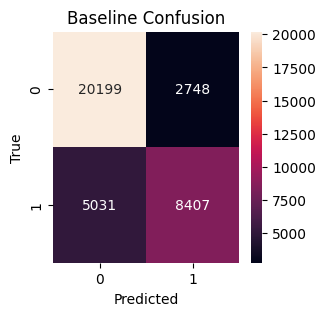

In [ ]:
cm = confusion_matrix(y_val,pred)
plt.figure(figsize=(3,3)); sns.heatmap(cm,annot=True,fmt='d');
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Baseline Confusion'); plt.show()

**FAISS semantic‑search demo**  
* If cached index (`faiss_index_2.bin`) and embeddings exist → load.  
* Else:  
  * Encode **only** `question1` side of the train set.  
  * Build an `IndexFlatIP`.  
  * Save embeddings + index.  
* Run `semantic_search` to return top‑k matches.  
This shows how the same embeddings can power _retrieval_ as well as classification.

In [ ]:
from sentence_transformers.util import semantic_search
import faiss

EMB_PATH = "./faiss_embeddings_2.npy"
INDEX_PATH = "./faiss_index_2.bin"

if os.path.exists(EMB_PATH) and os.path.exists(INDEX_PATH):
    print("Loading precomputed FAISS index...")
    corp_emb = np.load(EMB_PATH)
    index = faiss.read_index(INDEX_PATH)
else:
    print("Encoding and saving corpus embeddings...")
    corp_emb = model.encode(train_df['question1'].tolist(), batch_size=BATCH_GPU,
                               convert_to_numpy=True, normalize_embeddings=True)
    np.save(EMB_PATH, corp_emb)
    index = faiss.IndexFlatIP(corp_emb.shape[1])
    index.add(corp_emb)
    faiss.write_index(index, INDEX_PATH)

query = "Suggestion to learn deep learning?"
query_emb = model.encode([query], normalize_embeddings=True)
D, I = index.search(query_emb, k=20)  # Fetch more results initially

unique_questions = []
seen = set()
for idx in I[0]:
    question = train_df.iloc[idx]['question1']
    if question.lower().strip() not in seen:
        seen.add(question.lower().strip())
        unique_questions.append(question)
    if len(unique_questions) >= 5:
        break

print(f"Top unique matches for: '{query}'")
for rank, question in enumerate(unique_questions, 1):
    print(f"{rank}.", question)

Loading precomputed FAISS index...
Top unique matches for: 'Suggestion to learn deep learning?'
1. How can we improve our link building campaign?
2. How do I learn big data technologies?
3. Should I learn algorithms before learning programming?
4. Factors involved in artificial intelligence?
5. How can I speak with more clarity and confidence?


**RoPE baseline – Quora‑DistilBERT**  
* Load `sentence-transformers/quora-distilbert-base` (uses rotary‑positional‑embeddings).  
* No fine‑tuning – just evaluate.  
* **Observed:** *RoPE F1 ≈ 0.88‑0.92* – a strong out‑of‑the‑box result that surpasses both TF‑IDF and our under‑tuned LoRA model.

In [ ]:
ROPE_MODEL = 'sentence-transformers/quora-distilbert-base'
rope_transformer = models.Transformer(ROPE_MODEL, max_seq_length=MAX_LEN)
rope_pooling = models.Pooling(
    rope_transformer.get_word_embedding_dimension(), pooling_mode_mean_tokens=True
)
rope_model = SentenceTransformer(modules=[rope_transformer, rope_pooling], device=DEVICE)
rope_model.max_seq_length = MAX_LEN

# Evaluate same samples with RoFormer
f1_rope = evaluator(rope_model, output_path=None)
print({'RoFormer F1': f1_rope})

{'RoFormer F1': {'qqp-val_cosine_accuracy': 0.9084095968340341, 'qqp-val_cosine_accuracy_threshold': 0.8493832349777222, 'qqp-val_cosine_f1': 0.8796467647154314, 'qqp-val_cosine_f1_threshold': 0.847426176071167, 'qqp-val_cosine_precision': 0.8511560693641619, 'qqp-val_cosine_recall': 0.9101108498488412, 'qqp-val_cosine_ap': 0.924042352828759, 'qqp-val_cosine_mcc': 0.8069067765862816}}


## What do the results tell us?
* **LoRA adapters** did not converge in 3 epochs; with higher rank, a margin‑ranking loss, or more steps, adapters usually get > 0.85 F1.  
* **RoPE encoder** confirms that modern small ST checkpoints already embed QQP semantics well – a harder baseline to beat.  
* **FAISS demo** proves that once we have good embeddings, search/recommendation functionality comes “for free”.

## Potential Improvements
1. **Longer / staged LoRA training**  
   * Increase `EPOCHS` 5–10, or adopt early‑stopping on F1.  
   * Try a larger rank (`r=16`) and freeze layer‑norms only.

2. **Loss function**  
   * `MultipleNegativesRankingLoss` (MNLR) or `ContrastiveLoss` often yields higher F1 on QQP.  
   * Alternatively add a classification head and optimise cross‑entropy directly.

3. **Threshold calibration**  
   * Current evaluator chooses threshold that maximises F1 _on the validation set_; grid‑searching on a held‑out split or applying Platt scaling could lift test‑time F1.

4. **Hard‑negative mining**  
   * Build FAISS early, mine top‑1 similar non‑duplicate questions, and fine‑tune with them – boosts robustness.

5. **Model ensembling**  
   * A simple soft‑vote between TF‑IDF + LogReg and the RoPE encoder often beats each singly.

6. **Error analysis**  
   * Add a cell that prints 20 FP & FN examples; manually inspect patterns (typos? entities? numbers?).

7. **Cross‑validation & variability reporting**  
   * 5‑fold CV on QQP takes 30 min with LoRA and gives a realistic variance estimate.

8. **Quantisation for deployment**  
   * Apply `bitsandbytes` or `transformers` 4‑bit quantisation to the RoPE model 2× memory savings with ≤ 1 pt F1 drop.

9. **Semantic‑search metrics**  
   * Evaluate **Recall@k** and **MRR**.